# Contextual Bandit

Contextual bandit is a simpler version of reinforcement learning problem, where there is just one timestep and immediate reward. It is used for example in ad placement, where the model has to propose ads for an user and receives feedback whether user clicked on it.

## Policy Gradients

The policy gradient formulation can be easily used with contextual bandit. Because there is only one timestep, we can replace the return with immediate reward and baseline with mean of those rewards:

$$
L = -\sum_{i=0}^n \log \pi_{\theta}(a_i|s_i) (r_i - \bar{r})
$$

Actually this formulation is very general and can be used to optimize any non-differentiable objective function. In this case $r_i$ would be the value of that objective function and $\bar{r}$ is the average of that objective function.

## Fashion-MNIST

Fashion-MNIST is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for popular MNIST dataset of handwritten digits. The class labels are:

|Label|Description|
|-----|-----------|
|0    |T-shirt/top|
|1    |Trouser    |
|2    |Pullover   |
|3    |Dress      |
|4    |Coat       |
|5    |Sandal     |
|6    |Shirt      |
|7    |Sneaker    |
|8    |Bag        |
|9    |Ankle boot |

In [1]:
from keras.datasets import fashion_mnist
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

Using TensorFlow backend.


In [2]:
# load Fashion-MNIST dataset
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

# normalize inputs to the network between 0 and 1
trainX = trainX / 255.0
testX = testX / 255.0

# names of classes
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

4423680/4422102 [==============================] - 1s 0us/step


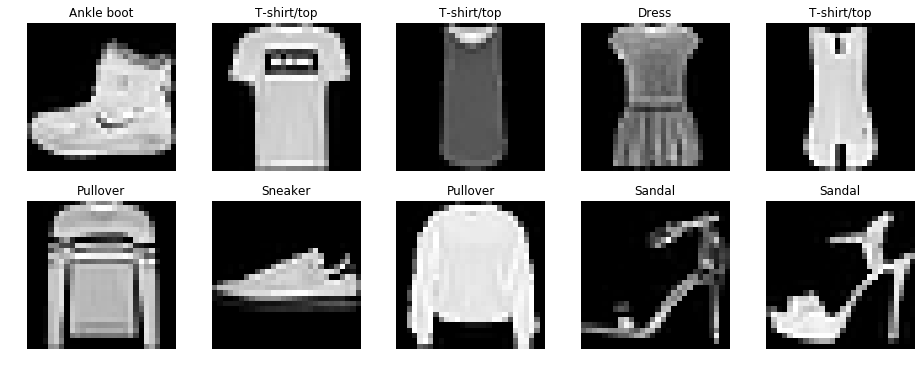

In [3]:
# plot some sample images
plt.figure(figsize=(16, 6))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(trainX[i], cmap='gray')
  plt.title(class_names[trainY[i]])
  plt.axis('off')

## Supervised learning

First try normal supervised learning.

In [4]:
# create a simple one hidden layer network
x = Input(shape=trainX.shape[1:])
f = Flatten()(x)
h = Dense(128, activation='relu')(f)
p = Dense(10, activation='softmax')(h)

model = Model(x, p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [5]:
# fit the model
model.fit(trainX, trainY, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 9s 147us/step - loss: 0.5008 - acc: 0.8239
Epoch 2/5
60000/60000 [==============================] - 8s 137us/step - loss: 0.3766 - acc: 0.8644
Epoch 3/5
60000/60000 [==============================] - 8s 140us/step - loss: 0.3392 - acc: 0.8758
Epoch 4/5
60000/60000 [==============================] - 8s 139us/step - loss: 0.3136 - acc: 0.8849
Epoch 5/5
60000/60000 [==============================] - 9s 143us/step - loss: 0.2966 - acc: 0.8903


In [6]:
loss, accuracy = model.evaluate(testX, testY)
print("Test accuracy:", accuracy)

10000/10000 [==============================] - 1s 58us/step
Test accuracy: 0.8691


## Reinforcement Learning

Now let's play a game: suppose we have 10 different users, each one liking only images from one category. For each image the network has to propose to which user to show it. The feedback is in the form of clicks - if the correct category image was shown to the user, then she will click on it.

Actually the task is basically the same as in supervised learning, just framed in a different way and we will use policy gradients to train the network.

In [7]:
from keras.initializers import RandomNormal

x = Input(shape=trainX.shape[1:])
f = Flatten()(x)
h = Dense(128, activation='relu')(f)
# initialize last layer closer to zero to have more uniform predictions initially
p = Dense(10, activation='softmax', kernel_initializer=RandomNormal(stddev=0.01))(h)

model = Model(x, p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [8]:
EPOCHS = 20
BATCHSIZE = 100

idx = np.arange(len(trainX))
for epoch in range(EPOCHS):
    np.random.shuffle(idx)
    for batch in range(0, len(idx), BATCHSIZE):
        # prepare batch
        states = trainX[idx[batch:batch + BATCHSIZE]]
        labels = trainY[idx[batch:batch + BATCHSIZE]]

        # predict probabilities for actions
        probs = model.predict_on_batch(states)
        # sample actions
        actions = [np.random.choice(10, p=p) for p in probs]

        # simulate feedback (clicks=rewards)
        rewards = (actions == labels)
        # calculate baseline as mean reward, basically accuracy
        baseline = np.mean(rewards)
        # calculate advantages
        advantages = rewards - baseline

        # train model with advantages as sample weights
        model.train_on_batch(states, actions, sample_weight=advantages)
        
        #print("Batch: ", batch, "Accuracy: ", baseline)

    loss, accuracy = model.evaluate(trainX, trainY, verbose=0)
    print("Epoch:", epoch + 1, "Train accuracy:", accuracy)

Epoch: 1 Train accuracy: 0.63025
Epoch: 2 Train accuracy: 0.678
Epoch: 3 Train accuracy: 0.6892166666666667
Epoch: 4 Train accuracy: 0.7327333333333333
Epoch: 5 Train accuracy: 0.7499166666666667
Epoch: 6 Train accuracy: 0.73415
Epoch: 7 Train accuracy: 0.7556666666666667
Epoch: 8 Train accuracy: 0.7559666666666667
Epoch: 9 Train accuracy: 0.75675
Epoch: 10 Train accuracy: 0.7537166666666667
Epoch: 11 Train accuracy: 0.7561166666666667
Epoch: 12 Train accuracy: 0.75585
Epoch: 13 Train accuracy: 0.7704833333333333
Epoch: 14 Train accuracy: 0.7683
Epoch: 15 Train accuracy: 0.77155
Epoch: 16 Train accuracy: 0.7697166666666667
Epoch: 17 Train accuracy: 0.7661666666666667
Epoch: 18 Train accuracy: 0.7579
Epoch: 19 Train accuracy: 0.76645
Epoch: 20 Train accuracy: 0.7798166666666667


In [9]:
loss, accuracy = model.evaluate(testX, testY)
print("Test accuracy:", accuracy)

10000/10000 [==============================] - 1s 51us/step
Test accuracy: 0.7641


## Conclusions

* Reinforcement learning takes much longer to converge than supervised learning. If ever possible, use supervised learning.
* But if your only feedback is in the form of rewards, then policy gradients are relatively easy to integrate with Keras.
* Policy gradients can be used to optimize any non-differentiable loss function.

## Bonus

Efficient Keras implementation for training with non-differentiable loss function using policy gradients.

In [10]:
import tensorflow as tf
from keras.metrics import sparse_categorical_accuracy

x = Input(shape=trainX.shape[1:])
f = Flatten()(x)
h = Dense(128, activation='relu')(f)
p = Dense(10, kernel_initializer=RandomNormal(stddev=0.01))(h)

def policy_gradient_loss(labels, logits):
    # convert labels to integers and strip redundant dimension
    labels = tf.cast(labels, tf.int64)[:, 0]
    # sample actions from logits, strip redundant dimension
    actions = tf.random.categorical(logits, 1)[:, 0]

    # simulate rewards: reward = 1 when the prediction was correct
    rewards = tf.cast(tf.equal(actions, labels), tf.float32)
    # baseline is mean reward of batch, basically accuracy
    baseline = tf.reduce_mean(rewards)
    # advantage is positive for correct predictions, negative for incorrect
    advantages = rewards - baseline

    # calculate categorical cross-entropy against sampled actions, weighted by advantages
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=actions, logits=logits) * advantages
    
model = Model(x, p)
model.compile(loss=policy_gradient_loss, optimizer=Adam(lr=0.001), metrics=[sparse_categorical_accuracy])

model.summary()

AttributeError: module 'tensorflow._api.v1.random' has no attribute 'categorical'

In [11]:
# fit the model
model.fit(trainX, trainY, epochs=20, batch_size=100)

Epoch 1/20
60000/60000 [==============================] - 1s 23us/step - loss: -0.0967 - sparse_categorical_accuracy: 0.6557
Epoch 2/20
60000/60000 [==============================] - 1s 21us/step - loss: -0.0436 - sparse_categorical_accuracy: 0.7264
Epoch 3/20
60000/60000 [==============================] - 1s 21us/step - loss: -0.0311 - sparse_categorical_accuracy: 0.7363
Epoch 4/20
60000/60000 [==============================] - 1s 21us/step - loss: -0.0306 - sparse_categorical_accuracy: 0.7373
Epoch 5/20
60000/60000 [==============================] - 1s 21us/step - loss: -0.0238 - sparse_categorical_accuracy: 0.7424
Epoch 6/20
60000/60000 [==============================] - 1s 20us/step - loss: -0.0281 - sparse_categorical_accuracy: 0.7494
Epoch 7/20
60000/60000 [==============================] - 1s 20us/step - loss: -0.0347 - sparse_categorical_accuracy: 0.7683
Epoch 8/20
60000/60000 [==============================] - 1s 20us/step - loss: -0.0318 - sparse_categorical_accuracy: 0.7760


In [12]:
loss, accuracy = model.evaluate(testX, testY)
print("Test accuracy:", accuracy)

10000/10000 [==============================] - 0s 18us/step
Test accuracy: 0.8451
